In [2]:
import pandas as pd
import numpy as np

In [3]:
# to display 2 digits in pandas dataframe float numbers
pd.options.display.float_format = '{:.2f}'.format #2 referring to number of digits and f referring to float

# Part 1
## Question 1

In [5]:
import glob

long = pd.DataFrame()

for filename in list(glob.glob('/Users/bilalakbar/Desktop/ECON433/*.csv.zip')):
    print(filename)
    
    data_temp = pd.read_csv(filename, compression = 'zip')
    print(len(data_temp))
    #print("Initial data preview:") # blah
    #print(data_temp.head())  # Preview initial data
    
    # replace the data with a 0.5% sample
    data_temp = data_temp.sample(frac = .005, random_state =1)
    
    # Filter for Zaxby's locations
    data_temp = data_temp[data_temp['brands'] == "Zaxby's"]
    if len(data_temp) == 0:  # Skip further processing if no Zaxby's data is found in the file
        continue
        
    # convert data types
    date_cols = ['date_range_start', 'date_range_end']
    data_temp[date_cols] = (data_temp[date_cols]
                           .apply(lambda x: x.str[:10])) # cut off string at 10 characters
    data_temp[date_cols] = data_temp[date_cols].apply(pd.to_datetime) # convert
    #print("\nData preview after date conversion:")
    #print(data_temp.head())  # Preview after converting dates
    
    # split visits by day
    data_temp['visits_by_day'] = (data_temp['visits_by_day']
                                 .str.replace('[', ''))
    data_temp['visits_by_day'] = (data_temp['visits_by_day']
                                 .str.replace(']', ''))
    
    dailyvisits = ['dailyvisits{}'.format(i+1) for i in range(7)]
    data_temp[dailyvisits] = (data_temp['visits_by_day']
                             .str.split(',', expand = True))
    
    #wide to long
    data_temp['id'] = data_temp.index
    data_temp.drop(columns = ['visits_by_day'], inplace = True)
    long_temp = pd.wide_to_long(data_temp,
                                ['dailyvisits'],
                                i = 'id',
                                j = 'day')
    long_temp.dropna(inplace = True)
    long_temp.reset_index(inplace = True)
    long_temp['dailyvisits'] = long_temp['dailyvisits'].astype(int)
    l3 = len(long_temp)
    #print(f"\nLength after wide to long transformation: {len(long_temp)} rows") #
    #print("Preview after wide to long transformation:") #
    #print(long_temp.head())  # Preview after wide to long transformation
    
    # create date variable
    long_temp['date'] = (long_temp['date_range_start']
                         + pd.to_timedelta(long_temp['day']-1,
                                            unit = 'd'))
    long_temp['dayofweek'] = long_temp['date'].dt.day_name()
    
    #create manyvisits variable
    threshold = long_temp['dailyvisits'].mean()
    long_temp['manyvisits'] = (long_temp['dailyvisits'] 
                               > threshold).astype(int) 
    #1 if dailyvisits exceeds the threshold, otherwise 0
    # Number of units per region 
    units_per_region = long_temp['region'].value_counts()

    # Threshold - the 80th percentile of units_per_region
    threshold_units = units_per_region.quantile(0.7) 
    
    # Add 'core_biz_area' variable based on 'region' and predefined threshold
    long_temp['core_biz_area'] = (long_temp['region'].apply
                                  (lambda x: 1 if 
                                   units_per_region.get(x, 0) 
                                   >= threshold_units else 0))
    
    # create weekend variable
    long_temp['weekend'] = (np.where(long_temp['dayofweek']
                            .isin(['Saturday', 'Sunday']),1, 0))
    
    long = pd.concat([long, long_temp], ignore_index = True)

long.drop(['date_range_end'], axis = 1, inplace = True)

# Save the concatenated and processed data to a CSV file
long.to_csv('/Users/bilalakbar/Desktop/ECON433/weekly_patterns_long_sample_proj2.csv',
                 index = False)

# Finally, show the head of the combined DataFrame
#print("\nFinal combined data preview:")
long.head()  # Preview the final combined DataFrame

/Users/bilalakbar/Desktop/ECON433/weekly_patterns_2022_sample.csv.zip
1315076
/Users/bilalakbar/Desktop/ECON433/weekly_patterns_2020_sample.csv.zip
1280931
/Users/bilalakbar/Desktop/ECON433/weekly_patterns_2021_sample.csv.zip
1294674
/Users/bilalakbar/Desktop/ECON433/weekly_patterns_2019_sample.csv.zip
1275056
/Users/bilalakbar/Desktop/ECON433/weekly_patterns_2018_sample.csv.zip
1296498


,id,day,postal_code,brands,placekey,region,city,safegraph_brand_ids,naics_code,date_range_start,raw_visit_counts,dailyvisits,date,dayofweek,manyvisits,core_biz_area,weekend
0,455175,1,37323,Zaxby's,222-222@8g8-zkv-835,TN,Cleveland,SG_BRAND_5271fc9e8c38fe53392a2ecabc642130,722513,2022-11-14,305,35,2022-11-14,Monday,0,1,0
1,456836,1,27262,Zaxby's,22q-222@63g-5td-t9z,NC,High Point,SG_BRAND_5271fc9e8c38fe53392a2ecabc642130,722513,2022-03-28,149,16,2022-03-28,Monday,0,1,0
2,455083,1,30655,Zaxby's,zzw-222@8g6-z5s-ygk,GA,Monroe,SG_BRAND_5271fc9e8c38fe53392a2ecabc642130,722513,2022-03-28,602,74,2022-03-28,Monday,1,1,0
3,451870,1,36092,Zaxby's,222-222@8gn-n3p-2zf,AL,Wetumpka,SG_BRAND_5271fc9e8c38fe53392a2ecabc642130,722513,2022-07-18,444,64,2022-07-18,Monday,1,0,0
4,453936,1,30830,Zaxby's,223-222@8g7-6wr-9cq,GA,Waynesboro,SG_BRAND_5271fc9e8c38fe53392a2ecabc642130,722513,2022-10-10,367,41,2022-10-10,Monday,1,1,0


In [6]:
# datetime
long['date'] = long['date'].astype('datetime64[ns]')
long['date_range_start'] = (long['date_range_start'].
                            astype('datetime64[ns]'))

# read census region data from github
url = 'https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv' 
region = pd.read_csv(url, index_col=0)
region.head()

# change colnames so that key variables match
long.rename(columns = {'region': 'state'},
               inplace = True)
region.rename(columns = {'State Code': 'state'}, 
               inplace = True)
# merge
long = pd.merge(long, region, on = 'state', how = 'inner')
long.to_csv('/Users/bilalakbar/Desktop/ECON433/weekly_patterns_long_sample_proj2TEST.csv',
                 index = False)
long.head()

,id,day,postal_code,brands,placekey,state,city,safegraph_brand_ids,naics_code,date_range_start,raw_visit_counts,dailyvisits,date,dayofweek,manyvisits,core_biz_area,weekend,Region,Division
0,455175,1,37323,Zaxby's,222-222@8g8-zkv-835,TN,Cleveland,SG_BRAND_5271fc9e8c38fe53392a2ecabc642130,722513,2022-11-14,305,35,2022-11-14,Monday,0,1,0,South,East South Central
1,450494,1,37323,Zaxby's,222-222@8g8-zkv-835,TN,Cleveland,SG_BRAND_5271fc9e8c38fe53392a2ecabc642130,722513,2022-02-21,393,45,2022-02-21,Monday,1,1,0,South,East South Central
2,454724,1,37130,Zaxby's,222-222@5pn-qzb-3h5,TN,Murfreesboro,SG_BRAND_5271fc9e8c38fe53392a2ecabc642130,722513,2022-07-25,201,26,2022-07-25,Monday,0,1,0,South,East South Central
3,452964,1,37601,Zaxby's,223-222@8gf-npb-jgk,TN,Johnson City,SG_BRAND_5271fc9e8c38fe53392a2ecabc642130,722513,2022-07-11,210,26,2022-07-11,Monday,0,1,0,South,East South Central
4,453359,1,37130,Zaxby's,222-222@5pn-qzb-3h5,TN,Murfreesboro,SG_BRAND_5271fc9e8c38fe53392a2ecabc642130,722513,2022-06-06,217,25,2022-06-06,Monday,0,1,0,South,East South Central


**In your long data, what are the unique values of your dayofweek variable?** The unique values are each day of the week. In the `weekend` column, 0 means it Monday - Friday and 1 means Saturday or Sunday.

**How many observations do you have for weekend and weekdays?** 

In [7]:
# Count the number of observations for weekends and weekdays
weekend_weekday_counts = long['weekend'].value_counts().sort_index()

# Assuming 1 represents weekend and 0 represents weekday in the 'weekend' column
num_weekdays = weekend_weekday_counts.get(0, 0)
num_weekends = weekend_weekday_counts.get(1, 0)

print(f"Number of weekday observations: {num_weekdays}")
print(f"Number of weekend observations: {num_weekends}")

Number of weekday observations: 1085
Number of weekend observations: 434


# Part 2
## Question 2a

In [8]:
long['dailyvisits'].describe()

count   1519.00
mean      29.30
std       19.66
min        0.00
25%       16.00
50%       25.00
75%       38.00
max      145.00
Name: dailyvisits, dtype: float64

How many observations do you have? **1519**
Minimum? **0**
Maximum? **145**
Average? **29.30**
Median? **25**

How many observations have dailyvisits equal to zero? **9**

In [9]:
(long['dailyvisits'] == 0).sum()

9

How many observations have dailyvisits above 100 (including 100)? **12**

In [10]:
(long['dailyvisits'] >= 100).sum()

12

How many observations have dailyvisits above 1000 (including 1000)? **0**

In [11]:
(long['dailyvisits'] >= 1000).sum()

0

## Question 2b

<IPython.core.display.Javascript object>


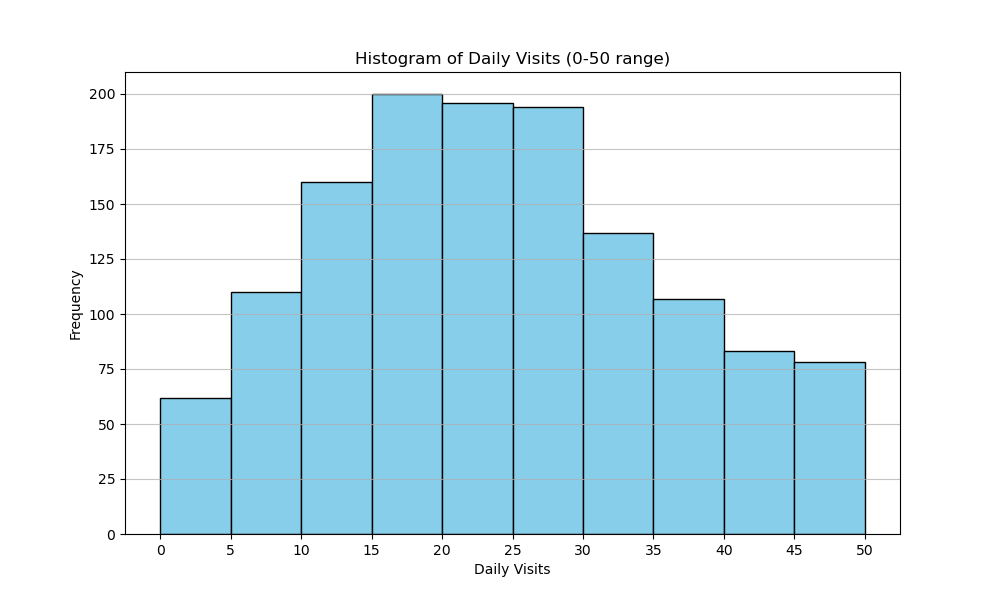

In [12]:
import matplotlib.pyplot as plt
%matplotlib notebook
# %matplotlib inline

plt.figure(figsize=(10, 6))  # Set figure size for better visibility
# Create histogram with specified range and bins
n, bins, patches = (plt.hist(long['dailyvisits'], 
                    bins=range(0, 51, 5), 
                    edgecolor='black', color='skyblue'))

plt.title('Histogram of Daily Visits (0-50 range)')
plt.xlabel('Daily Visits')
plt.ylabel('Frequency')
plt.xticks(range(0, 51, 5))  # Set x-ticks to align with the bins

plt.grid(axis='y', alpha=0.75)  # Add a y-axis grid for better readability

plt.show()

I first used 
```python 
plt.figure()
plt.hist(long['dailyvisits']);
``` 
and found that majority of my data was in <60 range, so I chose a sub-range of 0-50. This allowed me to concentrate on where the bulk of the data lies, and also helped in visually representing the data more effectively.

## Question 2c

<IPython.core.display.Javascript object>


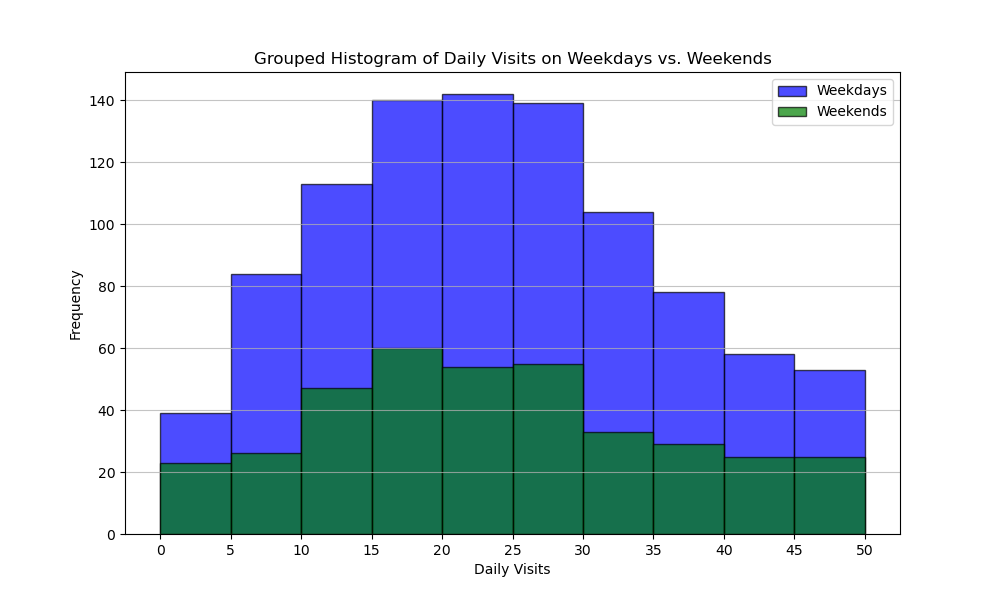

In [13]:
import matplotlib.pyplot as plt

# Separating data into weekdays and weekends
weekdays = long[long['weekend'] == 0]['dailyvisits']
weekends = long[long['weekend'] == 1]['dailyvisits']

# Same bin definition at 2b
bins = range(0, 51, 5) 

plt.figure(figsize=(10, 6))

# Plotting both histograms on the same figure
plt.hist(weekdays, bins=bins, alpha=0.7, label='Weekdays', color='blue', edgecolor='black')
plt.hist(weekends, bins=bins, alpha=0.7, label='Weekends', color='green', edgecolor='black')

plt.title('Grouped Histogram of Daily Visits on Weekdays vs. Weekends')
plt.xlabel('Daily Visits')
plt.ylabel('Frequency')
plt.xticks(bins)  # Set x-ticks to align with the bins
plt.legend()  # Add a legend to distinguish between weekdays and weekends
plt.grid(axis='y', alpha=0.75)

plt.show()


There seems to be more variance amongst bins for Weekdays. Weekend's variance stays around the 20 mark, whereas Weekdays jump up 40 at times.

# Part 3
## Question 3a

In [14]:
dv_sum = long[['dayofweek', 'dailyvisits']].groupby('dayofweek').sum()
dv_sum

,dailyvisits
dayofweek,
Friday,7289
Monday,5823
Saturday,6418
Sunday,6526
Thursday,6534
Tuesday,5851
Wednesday,6062


## Question 3b

<IPython.core.display.Javascript object>


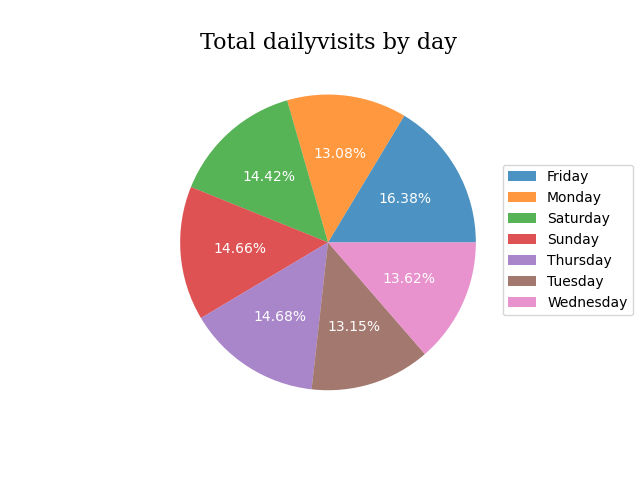

In [15]:
plt.figure()

plt.pie(dv_sum['dailyvisits'],
        labels = dv_sum.index,
        autopct = '%.2f%%',
        textprops={'color':'w', 'fontsize': 10},
        wedgeprops={'alpha': 0.8})
plt.title('Total dailyvisits by day',
          fontsize = 16,
          fontname = 'serif');

# Display the legend in a nicer way (s.t. it doesn't overlap with plot)
plt.legend (bbox_to_anchor = (1,0.5),
            loc = "center right",
            fontsize=10,
            bbox_transform=plt.gcf().transFigure);

# bbox_transform=plt.gcf().transFigure: have a coordinate system of the Figure
# bbox_to_anchor=(1,0.5): location of legend in the coordinate system 

# Part 4
## Question 4a

In [26]:
long.head()

,id,day,postal_code,brands,placekey,state,city,safegraph_brand_ids,naics_code,date_range_start,raw_visit_counts,dailyvisits,date,dayofweek,manyvisits,core_biz_area,weekend,Region,Division,Period
0,455175,1,37323,Zaxby's,222-222@8g8-zkv-835,TN,Cleveland,SG_BRAND_5271fc9e8c38fe53392a2ecabc642130,722513,2022-11-14,305,35,2022-11-14,Monday,0,1,0,South,East South Central,Post-COVID
1,450494,1,37323,Zaxby's,222-222@8g8-zkv-835,TN,Cleveland,SG_BRAND_5271fc9e8c38fe53392a2ecabc642130,722513,2022-02-21,393,45,2022-02-21,Monday,1,1,0,South,East South Central,Post-COVID
2,454724,1,37130,Zaxby's,222-222@5pn-qzb-3h5,TN,Murfreesboro,SG_BRAND_5271fc9e8c38fe53392a2ecabc642130,722513,2022-07-25,201,26,2022-07-25,Monday,0,1,0,South,East South Central,Post-COVID
3,452964,1,37601,Zaxby's,223-222@8gf-npb-jgk,TN,Johnson City,SG_BRAND_5271fc9e8c38fe53392a2ecabc642130,722513,2022-07-11,210,26,2022-07-11,Monday,0,1,0,South,East South Central,Post-COVID
4,453359,1,37130,Zaxby's,222-222@5pn-qzb-3h5,TN,Murfreesboro,SG_BRAND_5271fc9e8c38fe53392a2ecabc642130,722513,2022-06-06,217,25,2022-06-06,Monday,0,1,0,South,East South Central,Post-COVID


In [27]:
# Chose region as my geographic variable
region_ = (long[['dailyvisits', 'Region']]
           .groupby(['Region']).mean())
region_.reset_index(inplace = True)
region_

,Region,dailyvisits
0,Midwest,10.79
1,South,30.03
2,West,9.39


At first I thought I did something wrong for there to be no "Northeast" region in my table above. But after a little research, I found that Zaxby's only has one location in the Northeast region, in NY. This location was opened after this data was collected, which explains the lack of "Northeast". Here's the graph that helped me: 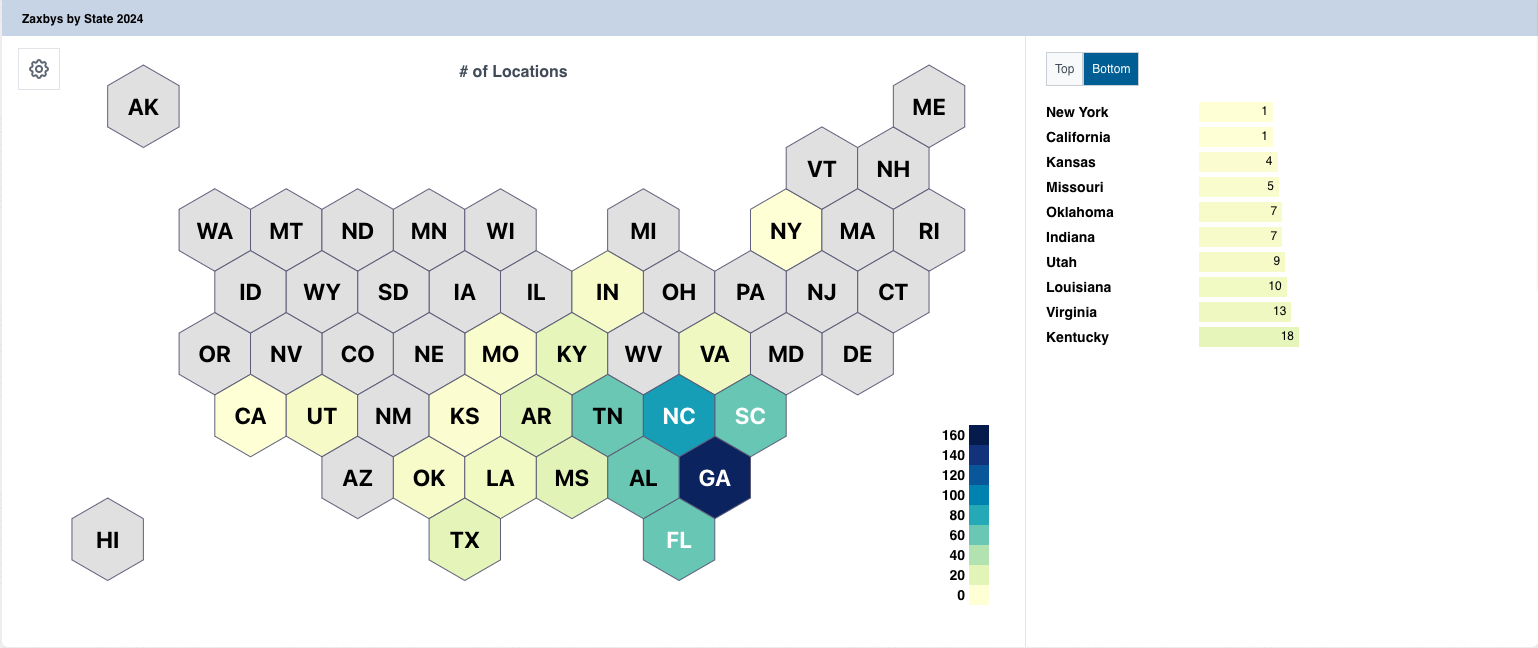

## Question 4b

<IPython.core.display.Javascript object>


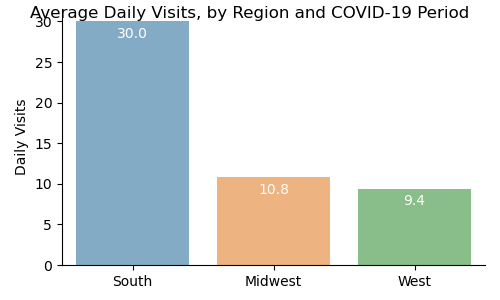

/Users/bilalakbar/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


In [29]:
import seaborn as sns

myplot = sns.catplot(
    data=region_, kind='bar',
    x='Region', y='dailyvisits',
    order = ['South', 'Midwest', 'West'],
    alpha=.6)

myplot.set_axis_labels("", "Daily Visits")
myplot.fig.suptitle("Average dailyvisits, by region",
                    fontsize=12);
plt.gcf().set_size_inches(5,3)

myplot.axes[0,0].bar_label(myplot.axes[0,0].containers[0],
                          fmt = '%.1f', # up to one decimal point
                          padding = -14,
                          color = 'white');

## Question 4c

In [30]:
# Create Period column for COVID
long['Period'] = ['Pre-COVID' if date <= pd.Timestamp('2020-03-13') else 'Post-COVID' for date in long['date']]
#long.head()
covid_bar = (long[['dailyvisits', 'Region', 'Period']]
              .groupby(['Region', 'Period']).mean())
covid_bar.reset_index(inplace = True)
covid_bar

,Region,Period,dailyvisits
0,Midwest,Post-COVID,16.14
1,Midwest,Pre-COVID,9.00
2,South,Post-COVID,34.24
3,South,Pre-COVID,23.47
4,West,Post-COVID,10.71
5,West,Pre-COVID,5.43


<IPython.core.display.Javascript object>


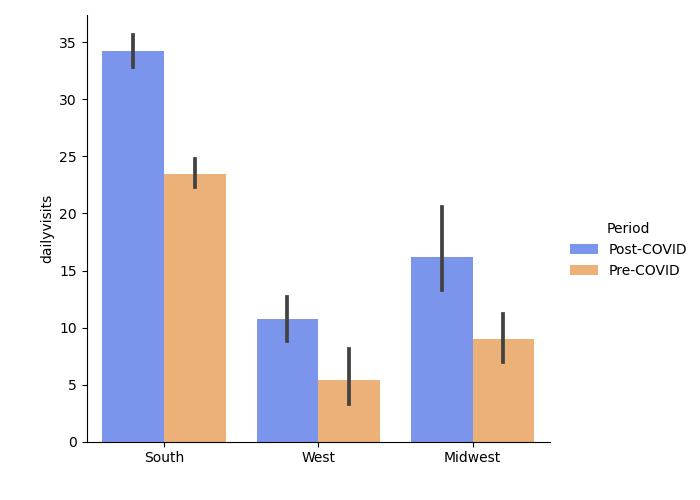

/Users/bilalakbar/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


In [31]:
ax = sns.catplot(
    data = long, kind = "bar",
    x="Region", y="dailyvisits",
    hue = "Period",
    palette = 'bright', alpha = .6, edgecolor= 'none')
myplot.fig.suptitle("Average Daily Visits, by Region and COVID-19 Period", fontsize=12)
ax.set_axis_labels("", 'dailyvisits')
plt.gcf().set_size_inches(7,5)

I don't understand where my title went. As you can see from my code, it should be there. But it's not. As for the differences, you can see that dailyvisits saw a hike Post-COVID in all regions. This could be due to effective marketing throughout the COVID period; garnering more available attention towards the franchise. Also, could just be a result of people finally getting out and overinduldging due to restrictions of the COVID period. I also don't know why the black lines are there. I troubleshooted a couple times, evident by the inclusion of the `edgecolor` command. 

Update: Ok, nevermind, they're just error bars representing the 95% confidence interval so I'll leave them in. 

# Part 5
## Question 5a

In [32]:
# new column for year-month
long['year_month'] = long['date'].dt.to_period('M')

average_dailyvisits_by_month = (long.groupby('year_month')
                                ['dailyvisits'].mean().
                                reset_index())
average_dailyvisits_by_month.columns = ['Year-Month', 'Average Daily Visits']
average_dailyvisits_by_month

,Year-Month,Average Daily Visits
0,2018-01,10.39
1,2018-02,11.19
2,2018-03,25.36
3,2018-04,14.00
4,2018-05,21.77
5,2018-06,20.95
6,2018-07,14.14
7,2018-08,16.52
8,2018-09,14.52
9,2018-10,19.21


## Question 5b

<IPython.core.display.Javascript object>


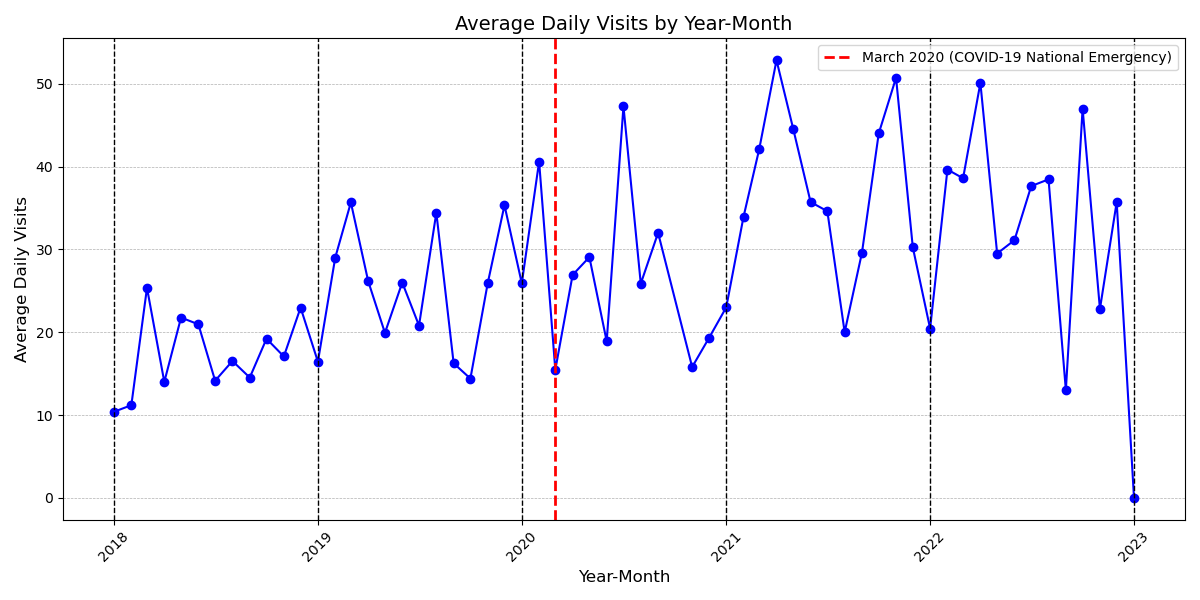

In [33]:
# Convert 'Year-Month' back to datetime to plot
average_dailyvisits_by_month['Year-Month'] = pd.to_datetime(average_dailyvisits_by_month['Year-Month'].astype(str))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot((average_dailyvisits_by_month['Year-Month'], 
          average_dailyvisits_by_month['Average Daily Visits'], 
          marker='o', linestyle='-', color='blue'))

# Adding vertical lines for the beginning of each year
years = average_dailyvisits_by_month['Year-Month'].dt.year.unique()
for year in years:
    plt.axvline(pd.to_datetime(f'{year}-01-01'), color='black', linestyle='--', lw=1)

# Adding a vertical line for March 2020
plt.axvline((pd.to_datetime('2020-03-01'), 
             color='red', 
             linestyle='--', 
             lw=2, 
             label='March 2020 (COVID-19 National Emergency)'))

# Plot details
plt.title('Average Daily Visits by Year-Month', fontsize=14)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Average Daily Visits', fontsize=12)
plt.xticks(rotation=45)  # better readability
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


## Question 5c

<IPython.core.display.Javascript object>


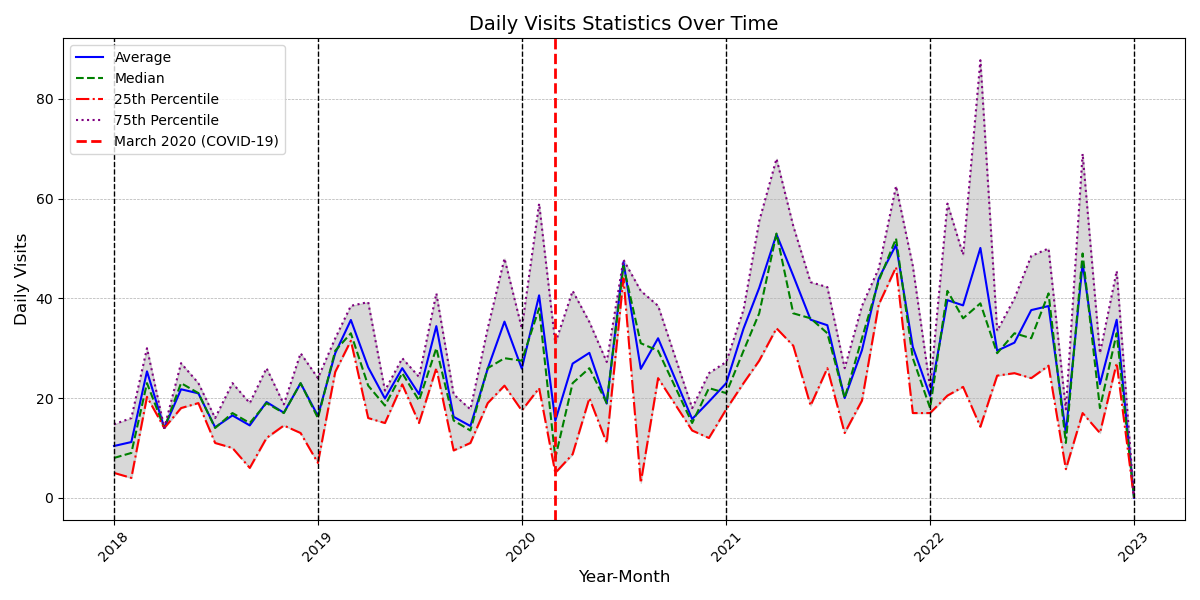

In [34]:
# Group by 'year_month' and calculate the required statistics
stats_df = long.groupby('year_month')['dailyvisits'].agg(['mean', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]).reset_index()
stats_df.columns = ['Year-Month', 'Average', 'Median', '25th Percentile', '75th Percentile']

# Convert 'Year-Month' back to datetime for plotting
stats_df['Year-Month'] = pd.to_datetime(stats_df['Year-Month'].astype(str))

plt.figure(figsize=(12, 6))

# Plotting each statistic
plt.plot(stats_df['Year-Month'], stats_df['Average'], label='Average', color='blue', linestyle='-')
plt.plot(stats_df['Year-Month'], stats_df['Median'], label='Median', color='green', linestyle='--')
plt.plot(stats_df['Year-Month'], stats_df['25th Percentile'], label='25th Percentile', color='red', linestyle='-.')
plt.plot(stats_df['Year-Month'], stats_df['75th Percentile'], label='75th Percentile', color='purple', linestyle=':')

# Shading the area between the 25th and 75th percentile
plt.fill_between((stats_df['Year-Month'], 
                  stats_df['25th Percentile'], 
                  stats_df['75th Percentile'], 
                  color='grey', 
                  alpha=0.3))

# Adding vertical lines for the beginning of each year
years = stats_df['Year-Month'].dt.year.unique()
for year in years:
    plt.axvline(pd.to_datetime(f'{year}-01-01'), color='black', linestyle='--', lw=1)

# Adding a vertical line for March 2020
plt.axvline((pd.to_datetime('2020-03-01'), 
             color='red', 
             linestyle='--', 
             lw=2, 
             label='March 2020 (COVID-19)'))

# Plot details
plt.title('Daily Visits Statistics Over Time', fontsize=14)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Daily Visits', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

We see wider distribution between the 25th and 75th percentiles AFTER the COVID-19 emergency announcement. The average 2023 daily visits are 0 in the data, which I assume is when they stopped collecting. 

# Part 6

<IPython.core.display.Javascript object>


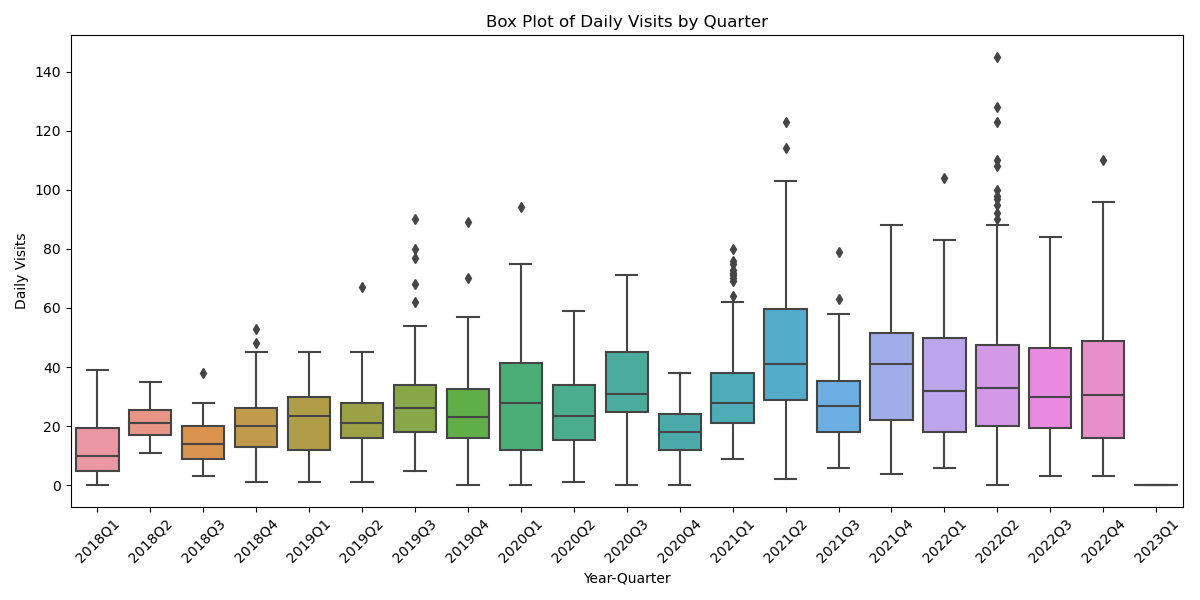

In [35]:
long['date'] = pd.to_datetime(long['date'])

# year-quarter
long['year_quarter'] = long['date'].dt.to_period('Q')
long_sorted = long.sort_values(by='year_quarter')

plt.figure(figsize=(12, 6))
sns.boxplot(x='year_quarter', y='dailyvisits', data=long_sorted)

plt.title('Box Plot of Daily Visits by Quarter')
plt.xlabel('Year-Quarter')
plt.ylabel('Daily Visits')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

We do see a general up trend in dailyvisits from 2018Q1 to 2022Q4. There is a peak around the Post-COVID 19 time, similar to the line chart in 5c. Throughout these years though, the median has not gon above 40; perhaps an indication to ramp up new locations or better incentivize current customers through a strong rewards program. Personally, this box plot is a lot easier for me to gain insights from compared to the line chart. 

# Part 7

/var/folders/nc/ldzhtb2s1s9d5p6_2fsqpd9m0000gn/T/ipykernel_21789/1358366716.py:15: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  geoData = geoData.explode()


<IPython.core.display.Javascript object>


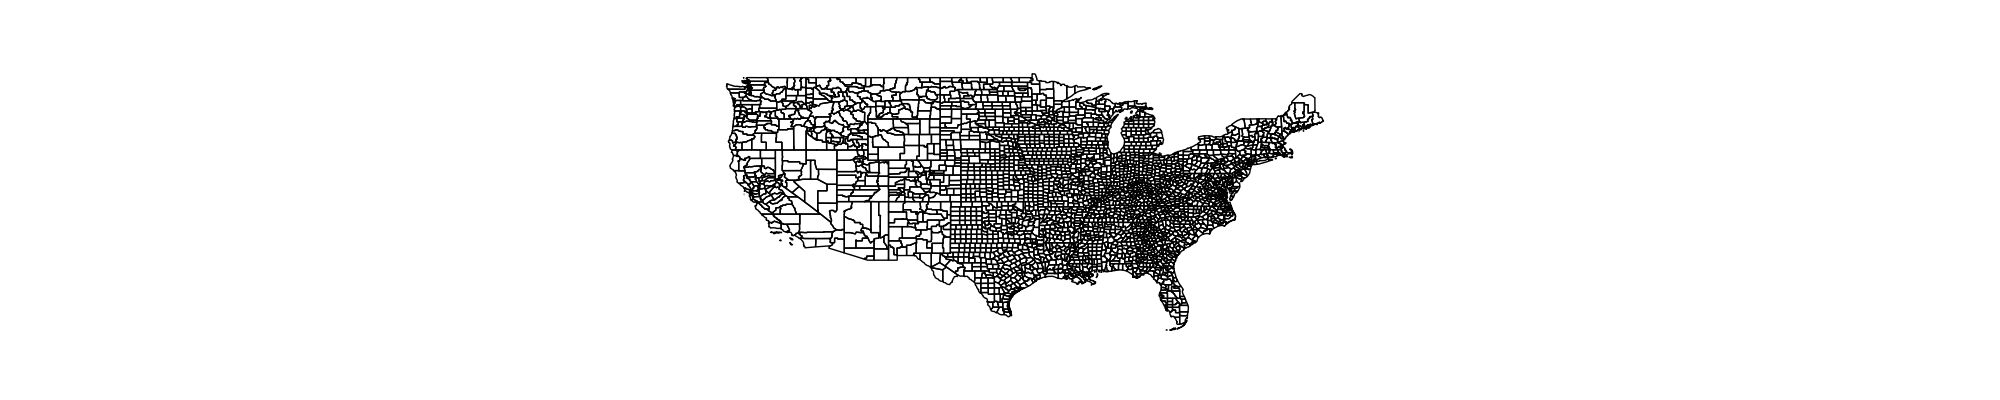

<Axes: >

In [36]:
import geopandas as gpd
import geoplot as gplt

# Load the json file with county coordinates
geoData = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

# Make sure the "id" column is an integer
geoData.id = geoData.id.astype(str).astype(int)

# Remove Alaska, Hawaii and Puerto Rico.
stateToRemove = ['02', '15', '72']
geoData = geoData[~geoData.STATE.isin(stateToRemove)]

# Convert MultiPolygon geometries to individual Polygon geometries
geoData = geoData.explode()

# Basic plot with just county outlines
gplt.polyplot(geoData, figsize=(20, 4))

In [55]:
geoData['STATE'].nunique()

49

In [56]:
geoData.head()

,,id,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
0,0,1001,0500000US01001,01,001,Autauga,County,594.44,"POLYGON ((-86.49677 32.34444, -86.71790 32.402..."
1,0,1009,0500000US01009,01,009,Blount,County,644.78,"POLYGON ((-86.57780 33.76532, -86.75914 33.840..."
2,0,1017,0500000US01017,01,017,Chambers,County,596.53,"POLYGON ((-85.18413 32.87053, -85.12342 32.772..."
3,0,1021,0500000US01021,01,021,Chilton,County,692.85,"POLYGON ((-86.51734 33.02057, -86.51596 32.929..."
4,0,1033,0500000US01033,01,033,Colbert,County,592.62,"POLYGON ((-88.13999 34.58170, -88.13925 34.587..."


<IPython.core.display.Javascript object>


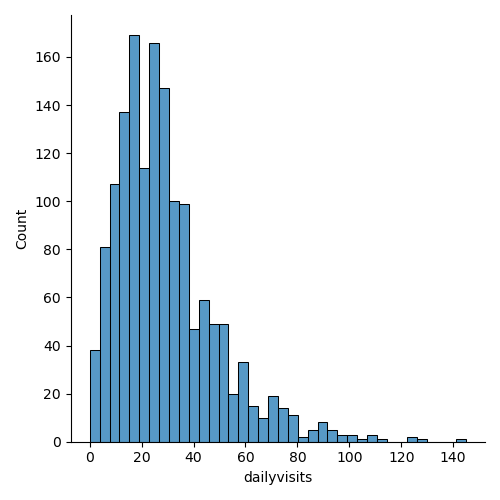

/Users/bilalakbar/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bilalakbar/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


In [41]:
import pandas as pd
import seaborn as sns
# Read file
data = pd.read_csv('weekly_patterns_long_sample_proj2TEST.csv')

# Show the distribution of dailyvisits
sns.displot( data["dailyvisits"]);

In [57]:
# STEP 1 sample code for creating a 'state_code' variable

import pandas as pd

state_id = {
    'AL': '01', 'AK': '02', 'AZ': '04', 'AR': '05', 'CA': '06',
    'CO': '08', 'CT': '09', 'DE': '10', 'FL': '12', 'GA': '13',
    'HI': '15', 'ID': '16', 'IL': '17', 'IN': '18', 'IA': '19',
    'KS': '20', 'KY': '21', 'LA': '22', 'ME': '23', 'MD': '24',
    'MA': '25', 'MI': '26', 'MN': '27', 'MS': '28', 'MO': '29',
    'MT': '30', 'NE': '31', 'NV': '32', 'NH': '33', 'NJ': '34',
    'NM': '35', 'NY': '36', 'NC': '37', 'ND': '38', 'OH': '39',
    'OK': '40', 'OR': '41', 'PA': '42', 'RI': '44', 'SC': '45',
    'SD': '46', 'TN': '47', 'TX': '48', 'UT': '49', 'VT': '50',
    'VA': '51', 'WA': '53', 'WV': '54', 'WI': '55', 'WY': '56',
}

long['state_code'] = long['state'].map(state_id)

long.head()

,id,day,postal_code,brands,placekey,state,city,safegraph_brand_ids,naics_code,date_range_start,...,dayofweek,manyvisits,core_biz_area,weekend,Region,Division,Period,year_month,year_quarter,state_code
0,455175,1,37323,Zaxby's,222-222@8g8-zkv-835,TN,Cleveland,SG_BRAND_5271fc9e8c38fe53392a2ecabc642130,722513,2022-11-14,...,Monday,0,1,0,South,East South Central,Post-COVID,2022-11,2022Q4,47
1,450494,1,37323,Zaxby's,222-222@8g8-zkv-835,TN,Cleveland,SG_BRAND_5271fc9e8c38fe53392a2ecabc642130,722513,2022-02-21,...,Monday,1,1,0,South,East South Central,Post-COVID,2022-02,2022Q1,47
2,454724,1,37130,Zaxby's,222-222@5pn-qzb-3h5,TN,Murfreesboro,SG_BRAND_5271fc9e8c38fe53392a2ecabc642130,722513,2022-07-25,...,Monday,0,1,0,South,East South Central,Post-COVID,2022-07,2022Q3,47
3,452964,1,37601,Zaxby's,223-222@8gf-npb-jgk,TN,Johnson City,SG_BRAND_5271fc9e8c38fe53392a2ecabc642130,722513,2022-07-11,...,Monday,0,1,0,South,East South Central,Post-COVID,2022-07,2022Q3,47
4,453359,1,37130,Zaxby's,222-222@5pn-qzb-3h5,TN,Murfreesboro,SG_BRAND_5271fc9e8c38fe53392a2ecabc642130,722513,2022-06-06,...,Monday,0,1,0,South,East South Central,Post-COVID,2022-06,2022Q2,47


In [74]:
fullData = pd.merge(geoData, long, left_on=['STATE'], right_on=['state_code'])
fullData.head()

,id_x,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,id_y,day,...,dayofweek,manyvisits,core_biz_area,weekend,Region,Division,Period,year_month,year_quarter,state_code
0,1001,0500000US01001,01,001,Autauga,County,594.44,"POLYGON ((-86.49677 32.34444, -86.71790 32.402...",451870,1,...,Monday,1,0,0,South,East South Central,Post-COVID,2022-07,2022Q3,01
1,1001,0500000US01001,01,001,Autauga,County,594.44,"POLYGON ((-86.49677 32.34444, -86.71790 32.402...",450600,1,...,Monday,1,0,0,South,East South Central,Post-COVID,2022-10,2022Q4,01
2,1001,0500000US01001,01,001,Autauga,County,594.44,"POLYGON ((-86.49677 32.34444, -86.71790 32.402...",453875,1,...,Monday,1,0,0,South,East South Central,Post-COVID,2022-02,2022Q1,01
3,1001,0500000US01001,01,001,Autauga,County,594.44,"POLYGON ((-86.49677 32.34444, -86.71790 32.402...",451320,1,...,Monday,0,0,0,South,East South Central,Post-COVID,2022-03,2022Q1,01
4,1001,0500000US01001,01,001,Autauga,County,594.44,"POLYGON ((-86.49677 32.34444, -86.71790 32.402...",458115,1,...,Monday,1,0,0,South,East South Central,Post-COVID,2022-07,2022Q3,01


<IPython.core.display.Javascript object>


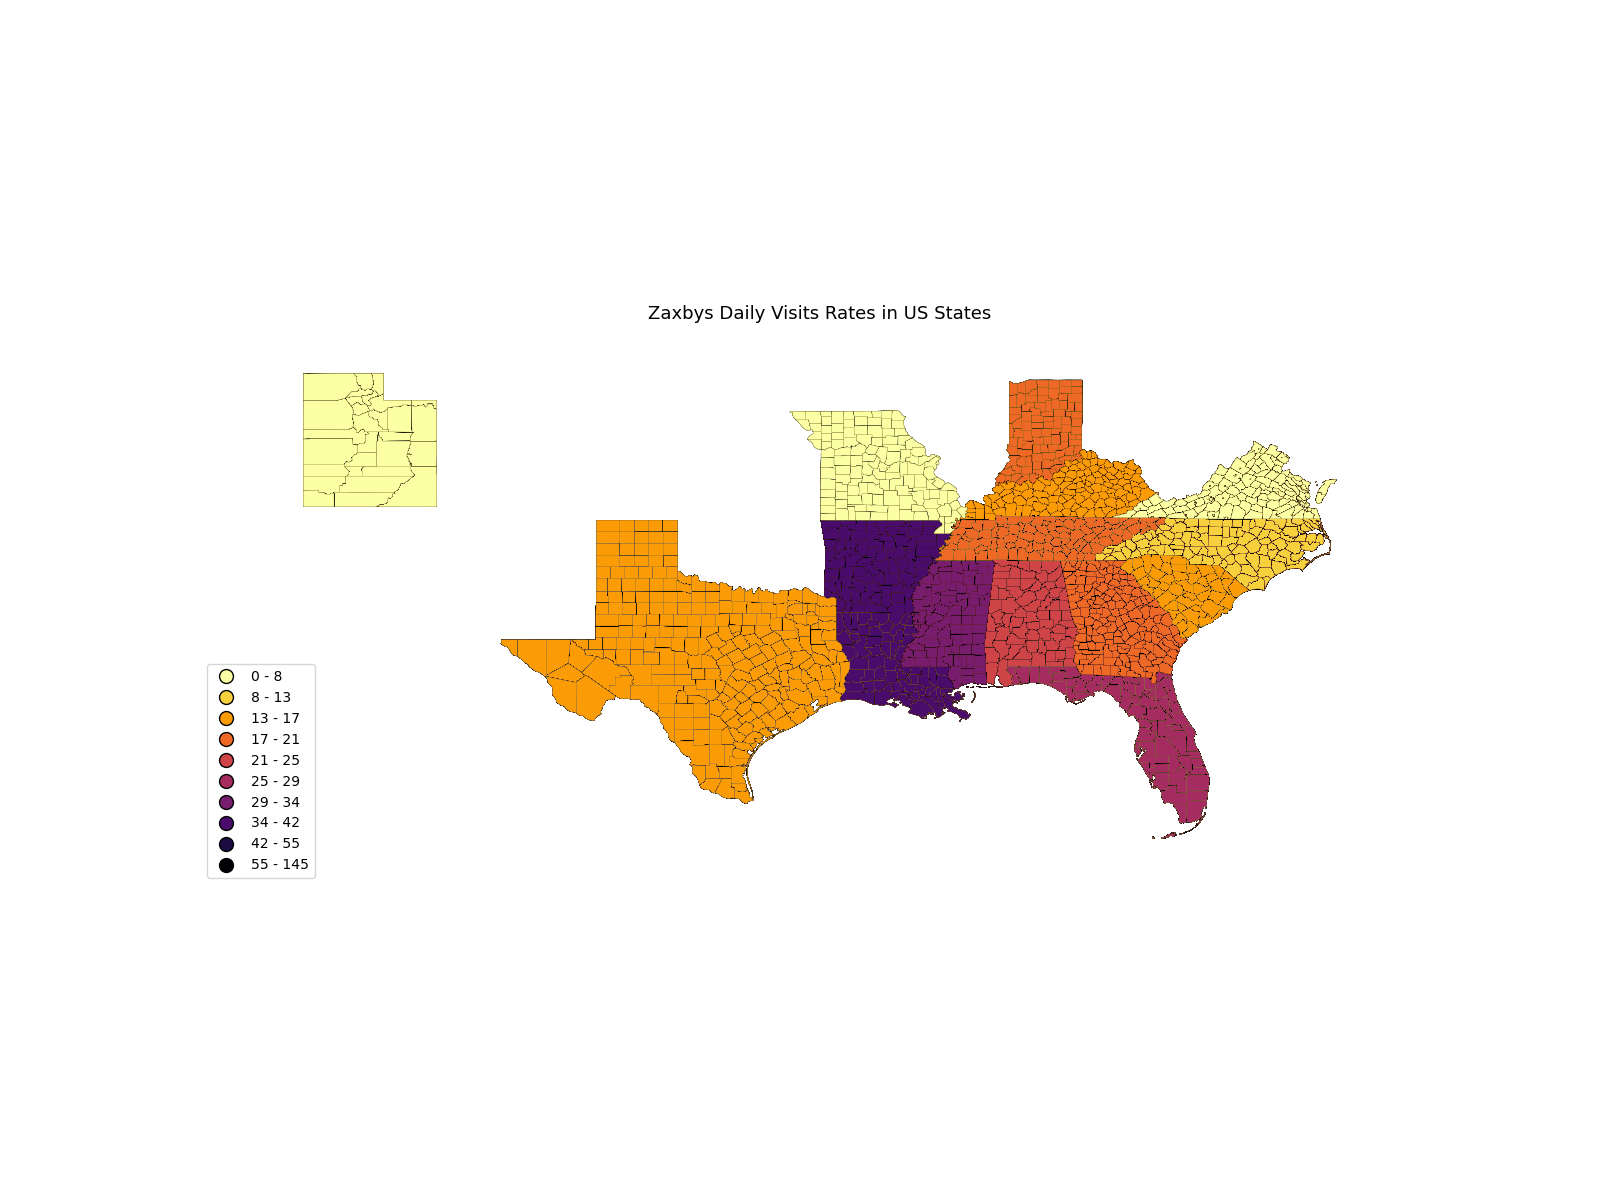

In [75]:
# Initialize the figure
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# Set up the color scheme:
import mapclassify as mc
scheme = mc.Quantiles(fullData['dailyvisits'], k=10)

# Map
gplt.choropleth(fullData, 
    hue="dailyvisits", 
    linewidth=.1,
    scheme=scheme, cmap='inferno_r',
    legend=True,
    edgecolor='black',
    ax=ax
);

ax.set_title('Zaxbys Daily Visits Rates in US States', fontsize=13);

The chart does pass the smell test. I compared it to the 2024 chart in Question 4a, and the higher density of Zaxby's in specific states contributes to the high number of dailyvisits in those states. I am not able to get an image of the entire map, perhaps because the states are white, meaning 0 Zaxby's. I can learn about which underserved states(meaning lower number of Zaxby's compared to other states) I need to pay more attention to, and perhaps look to expand in. With chains, I believe you have to grow outward from home. Wherever there is a high density of daily customers, you need to expand from there. Obviously, Zaxby's knows it is popular in the South, and Midwest already, bu they can use data like this to identify new surrounding territories to expand into, and take hold of unexplored opportunities. 